In [3]:
# Import libraries
import pickle
import requests
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fastai.tabular.all as fastai
np.set_printoptions(linewidth=130)
import torch

load_dotenv()
key = os.getenv('API_KEY')
api_url = "http://api.positionstack.com/v1/forward"

def load_pkl():
  longLats = pickle.load(open('./longLat.pkl', 'rb'))
  print(f"longLats loaded. {len(longLats)}")
  return longLats
longLats = load_pkl()

# clean up data: area, date, floor, price
def load_csv():
  #return pd.read_csv('./data/Woodlands_June22_May23.csv')
  return pd.read_csv('./data/resale-flat-from-jan-2017.csv')
floor_dict = { f'0{i*3+1} TO 0{i*3+3}' if i < 3 else f'{i*3+1} TO {i*3+3}': i*3+2  for i in range(17)  }
def floor_cleanup(df):
  df['floor'] = df.storey_range.apply(lambda x:float(floor_dict[x]) if isinstance(x,str) else x)
  df.drop(['storey_range'], axis=1, inplace=True)
  return df
date_dict = { f'20{17+i}-0{j+1}' if j < 9 else f'20{17+i}-{j+1}': i*12+j  for i in range(7) for j in range(12)  }
def date_cleanup(df):
  df['date'] = df.month.apply(lambda x:float(date_dict[x]) if isinstance(x,str) else x)
  df.drop(['month'], axis=1, inplace=True)
  return df
def load_and_cleanup():
  df = load_csv()
  df = floor_cleanup(df)
  df = date_cleanup(df)
  return df

df = load_and_cleanup()
df.describe()
date_max = df.date.max()
df = df[(df.town=="SENGKANG") & (df.date > date_max-12)]

from pathlib import Path
file = Path('./data/Sengkang_June22_May23.csv')
df.to_csv(file,index=False)
df


longLats loaded. 1771


,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
129122,SENGKANG,2 ROOM,467B,FERNVALE LINK,47.0,Model A,2016,93 years 04 months,300000.0,5.0,65.0
129123,SENGKANG,2 ROOM,418A,FERNVALE LINK,38.0,Model A,2018,95 years 02 months,300000.0,20.0,65.0
129124,SENGKANG,2 ROOM,445A,FERNVALE RD,47.0,Model A,2012,89 years 06 months,320000.0,20.0,65.0
129125,SENGKANG,2 ROOM,180B,RIVERVALE CRES,47.0,Model A,2015,91 years 10 months,315000.0,8.0,65.0
129126,SENGKANG,2 ROOM,180A,RIVERVALE CRES,47.0,Model A,2015,91 years 10 months,305000.0,17.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
153582,SENGKANG,EXECUTIVE,119C,RIVERVALE DR,142.0,Premium Apartment,2001,76 years 11 months,850000.0,14.0,76.0
153583,SENGKANG,EXECUTIVE,189B,RIVERVALE DR,131.0,Apartment,2000,76 years 03 months,660000.0,8.0,76.0
153584,SENGKANG,EXECUTIVE,189A,RIVERVALE DR,131.0,Apartment,2000,76 years 04 months,710000.0,17.0,76.0
153585,SENGKANG,EXECUTIVE,324C,SENGKANG EAST WAY,127.0,Apartment,2002,78 years 02 months,750000.0,5.0,76.0


In [4]:
blk_street = df.block + ' ' + df.street_name

responses = []
for i,add in enumerate(blk_street.unique()):
  response = requests.get(f"{api_url}?access_key={key}&query={add}+singapore")
  responses.append(response.json())
  first_response = response.json()['data'][0]
  if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
    longLats[f"{add}"] = (first_response['longitude'], first_response['latitude'])
    if (i%10==0):
      print(f"{i} of {len(blk_street.unique())}")
  else:
    print(f"check {add}. {first_response['label']}. confidence of {first_response['confidence']}")

pickle.dump(longLats, open('./longLat.pkl', 'wb'))
len(longLats)


467 Fernvale Link, Singapore, confidence 1, 0 of 564
436D Fernvale Road, Singapore, confidence 1, 10 of 564
336A Anchorvale Crescent, Singapore, confidence 1, 20 of 564
293 Compassvale Crescent, Singapore, confidence 1, 30 of 564
202A Compassvale Drive, Singapore, confidence 1, 40 of 564
298C Compassvale Street, Singapore, confidence 1, 50 of 564
435 Fernvale Road, Singapore, confidence 1, 60 of 564
check 446C JLN KAYU. Singapore. confidence of 0.6
162C Rivervale Crescent, Singapore, confidence 1, 70 of 564
323B Sengkang East Way, Singapore, confidence 1, 80 of 564
304A Anchorvale Link, Singapore, confidence 1, 90 of 564
295C Compassvale Crescent, Singapore, confidence 1, 100 of 564
291B Compassvale Street, Singapore, confidence 1, 110 of 564
407B Fernvale Road, Singapore, confidence 1, 120 of 564
260A Sengkang East Way, Singapore, confidence 1, 130 of 564
250A Compassvale Street, Singapore, confidence 1, 140 of 564
430 Fernvale Link, Singapore, confidence 1, 150 of 564
326B Anchorvale

2331

In [5]:
errors = [
  "446B JLN KAYU",
  "446C JLN KAYU",
  "447A JLN KAYU",
  "447B JLN KAYU",
]
len(errors)

4

In [6]:
df

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
129122,SENGKANG,2 ROOM,467B,FERNVALE LINK,47.0,Model A,2016,93 years 04 months,300000.0,5.0,65.0
129123,SENGKANG,2 ROOM,418A,FERNVALE LINK,38.0,Model A,2018,95 years 02 months,300000.0,20.0,65.0
129124,SENGKANG,2 ROOM,445A,FERNVALE RD,47.0,Model A,2012,89 years 06 months,320000.0,20.0,65.0
129125,SENGKANG,2 ROOM,180B,RIVERVALE CRES,47.0,Model A,2015,91 years 10 months,315000.0,8.0,65.0
129126,SENGKANG,2 ROOM,180A,RIVERVALE CRES,47.0,Model A,2015,91 years 10 months,305000.0,17.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
153582,SENGKANG,EXECUTIVE,119C,RIVERVALE DR,142.0,Premium Apartment,2001,76 years 11 months,850000.0,14.0,76.0
153583,SENGKANG,EXECUTIVE,189B,RIVERVALE DR,131.0,Apartment,2000,76 years 03 months,660000.0,8.0,76.0
153584,SENGKANG,EXECUTIVE,189A,RIVERVALE DR,131.0,Apartment,2000,76 years 04 months,710000.0,17.0,76.0
153585,SENGKANG,EXECUTIVE,324C,SENGKANG EAST WAY,127.0,Apartment,2002,78 years 02 months,750000.0,5.0,76.0


In [12]:
town = "Serangoon"
dfL = df[(~df.block.str.startswith('446'))&(~df.block.str.startswith('447'))]
file = Path(f'./data/{town}_June22_May23_without_newest.csv')
dfL.to_csv(file,index=False)
dfL

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
129122,SENGKANG,2 ROOM,467B,FERNVALE LINK,47.0,Model A,2016,93 years 04 months,300000.0,5.0,65.0
129123,SENGKANG,2 ROOM,418A,FERNVALE LINK,38.0,Model A,2018,95 years 02 months,300000.0,20.0,65.0
129124,SENGKANG,2 ROOM,445A,FERNVALE RD,47.0,Model A,2012,89 years 06 months,320000.0,20.0,65.0
129125,SENGKANG,2 ROOM,180B,RIVERVALE CRES,47.0,Model A,2015,91 years 10 months,315000.0,8.0,65.0
129126,SENGKANG,2 ROOM,180A,RIVERVALE CRES,47.0,Model A,2015,91 years 10 months,305000.0,17.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
153582,SENGKANG,EXECUTIVE,119C,RIVERVALE DR,142.0,Premium Apartment,2001,76 years 11 months,850000.0,14.0,76.0
153583,SENGKANG,EXECUTIVE,189B,RIVERVALE DR,131.0,Apartment,2000,76 years 03 months,660000.0,8.0,76.0
153584,SENGKANG,EXECUTIVE,189A,RIVERVALE DR,131.0,Apartment,2000,76 years 04 months,710000.0,17.0,76.0
153585,SENGKANG,EXECUTIVE,324C,SENGKANG EAST WAY,127.0,Apartment,2002,78 years 02 months,750000.0,5.0,76.0


In [8]:
df[(df.block.str.startswith('446'))|(df.block.str.startswith('447'))].describe()

,floor_area_sqm,lease_commence_date,resale_price,floor,date
count,16.000000,16.0,16.000000,16.000000,16.000000
mean,78.375000,2013.0,475229.000000,12.875000,70.562500
std,20.649052,0.0,107775.311513,5.886425,3.244868
min,47.000000,2013.0,263000.000000,5.000000,65.000000
25%,62.000000,2013.0,402972.000000,8.000000,67.750000
50%,93.000000,2013.0,539444.000000,11.000000,71.500000
75%,93.000000,2013.0,556250.000000,17.750000,73.000000
max,94.000000,2013.0,565000.000000,23.000000,75.000000


In [13]:
df = pd.read_csv(f'./data/Serangoon_June22_May23_without_newest.csv')
df

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
0,SENGKANG,2 ROOM,467B,FERNVALE LINK,47.0,Model A,2016,93 years 04 months,300000.0,5.0,65.0
1,SENGKANG,2 ROOM,418A,FERNVALE LINK,38.0,Model A,2018,95 years 02 months,300000.0,20.0,65.0
2,SENGKANG,2 ROOM,445A,FERNVALE RD,47.0,Model A,2012,89 years 06 months,320000.0,20.0,65.0
3,SENGKANG,2 ROOM,180B,RIVERVALE CRES,47.0,Model A,2015,91 years 10 months,315000.0,8.0,65.0
4,SENGKANG,2 ROOM,180A,RIVERVALE CRES,47.0,Model A,2015,91 years 10 months,305000.0,17.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
2070,SENGKANG,EXECUTIVE,119C,RIVERVALE DR,142.0,Premium Apartment,2001,76 years 11 months,850000.0,14.0,76.0
2071,SENGKANG,EXECUTIVE,189B,RIVERVALE DR,131.0,Apartment,2000,76 years 03 months,660000.0,8.0,76.0
2072,SENGKANG,EXECUTIVE,189A,RIVERVALE DR,131.0,Apartment,2000,76 years 04 months,710000.0,17.0,76.0
2073,SENGKANG,EXECUTIVE,324C,SENGKANG EAST WAY,127.0,Apartment,2002,78 years 02 months,750000.0,5.0,76.0


In [14]:
def lat_long(df):
  adds = (df.block + ' ' + df.street_name)
  longLat = adds.apply(lambda x: longLats[x])
  df['long'] = longLat.apply(lambda x: x[0])
  df['lat'] = longLat.apply(lambda x: x[1])
  return df
lat_long(df)
df.describe()

,floor_area_sqm,lease_commence_date,resale_price,floor,date,long,lat
count,2075.000000,2075.000000,2075.000000,2075.000000,2075.000000,2075.000000,2075.000000
mean,99.184096,2008.996145,570725.418313,9.999518,70.142169,103.892125,1.391396
std,17.394976,7.173157,101362.790037,5.620298,3.485406,0.010028,0.004663
min,38.000000,1998.000000,280000.000000,2.000000,65.000000,103.873108,1.381747
25%,92.000000,2001.000000,505000.000000,5.000000,67.000000,103.884550,1.388136
50%,94.000000,2012.000000,560000.000000,11.000000,70.000000,103.893338,1.391434
75%,112.000000,2016.000000,630000.000000,14.000000,73.000000,103.899473,1.395294
max,145.000000,2019.000000,935000.000000,26.000000,76.000000,103.909646,1.399618


In [15]:
dls = fastai.TabularDataLoaders.from_df(df,procs=[fastai.Normalize],cont_names=["floor", "floor_area_sqm", "lease_commence_date", "date", "lat","long"],y_names=["resale_price"])
dls.show_batch()

,floor,floor_area_sqm,lease_commence_date,date,lat,long,resale_price
0,2.0,90.000000,2001.0,75.0,1.392888,103.901711,460000.0
1,2.0,121.000000,1999.0,65.0,1.388672,103.898605,518000.0
2,2.0,93.000000,2018.0,66.0,1.399618,103.890022,495000.0
3,5.0,110.000000,2001.0,68.0,1.393169,103.895615,645000.0
4,5.0,111.000001,2003.0,74.0,1.392505,103.889977,575000.0
5,11.0,113.000000,2017.0,68.0,1.398640,103.896049,730000.0
6,14.0,124.000000,1999.0,66.0,1.382910,103.899864,628000.0
7,14.0,110.000000,2002.0,69.0,1.396191,103.899109,542000.0
8,11.0,112.000000,2015.0,75.0,1.394574,103.891350,737000.0
9,5.0,110.000000,2003.0,67.0,1.392180,103.907509,520000.0


SuggestedLRs(valley=0.0008317637839354575, slide=6.309573450380412e-07)

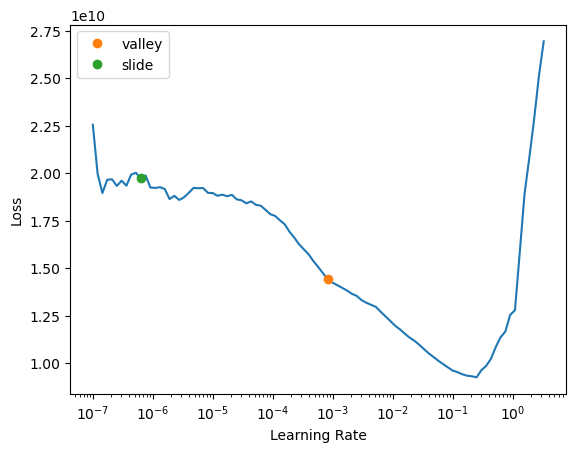

In [16]:
def MSE(yhat,y):
  return torch.mean(torch.square(yhat-y))
def RMSE(yhat,y):
  return torch.sqrt(MSE(yhat,y))
learn = fastai.tabular_learner(dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),loss_func=MSE,metrics=RMSE)
learn.lr_find(suggest_funcs=(fastai.valley,fastai.slide))


In [19]:
learn = fastai.tabular_learner(
  dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),
  loss_func=MSE,metrics=RMSE,
  cbs=[fastai.SaveModelCallback(),fastai.EarlyStoppingCallback(patience=5)]
)
learn.fit_one_cycle(100,1e-2)
learn.validate()


Better model found at epoch 0 with valid_loss value: 29084.31640625.


(#2) [854618880.0,29084.31640625]

In [18]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 30811.2578125.


(#2) [957257920.0,30811.2578125]

In [20]:
# predict prices on map
row = df.drop(['resale_price'], axis=1).iloc[0].copy()
cats = ['floor', 'floor_area_sqm', 'lease_commence_date', 'date']
for cat in cats:
  row[cat] = df[cat].median()
latMin, latMax = df.lat.min(),df.lat.max()
latLeft = latMin - (latMax-latMin)/10
latRight = latMax + (latMax-latMin)/10
longMin, longMax = df.long.min(),df.long.max()
longLeft = longMin - (longMax-longMin)/10
longRight = longMax + (longMax-longMin)/10
n1 = 10*15
n2 = 5*15
longs = np.linspace(longLeft, longRight, n1)
lats = np.linspace(latLeft, latRight, n2)
prices = np.ndarray((n2,n1))
for i,lat in enumerate(lats):
  if i%10==0: print(f"{i} of {n2}") 
  row['lat'] = lat
  for j,long in enumerate(longs):
    row['long'] = long
    with learn.no_bar(), learn.no_logging():
      _, yPred, _ = learn.predict(row)
      prices[i][j] = yPred.item()

0 of 150
10 of 150
20 of 150
30 of 150
40 of 150
50 of 150
60 of 150
70 of 150


In [22]:
import http.client, urllib.parse
import json

mrts = ["Buangkok MRT", "Sengkang MRT"]

def load_pkl():
    longLats = pickle.load(open('./longLat.pkl', 'rb'))
    print(f"longLats loaded. {len(longLats)}")
    return longLats
longLats = load_pkl()

responses = []
for mrt in mrts:
    conn = http.client.HTTPConnection('api.positionstack.com')
    params = urllib.parse.urlencode({
        'access_key': key,
        'query': mrt[:-4] + ' Station',
        'region': 'Singapore',
        'limit': 1,
    })
    conn.request('GET', '/v1/forward?{}'.format(params))
    res = conn.getresponse()
    data = res.read()
    first_response = json.loads(data.decode('utf-8'))['data'][0]
    responses.append(first_response)
    if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
        longLats[f"{mrt}"] = (first_response['longitude'], first_response['latitude'])
        print(f"{first_response['label']}, confidence {first_response['confidence']}")
    else:
        print(f"check {mrt}. {first_response['label']}. confidence of {first_response['confidence']}")

def dump_pkl(longLats):
    pickle.dump(longLats, open('./longLat.pkl', 'wb'))
    print(f"pickle dumped. {len(longLats)}")
dump_pkl(longLats)


longLats loaded. 1952
Buangkok Station, Singapore, confidence 1
Sengkang Station, Singapore, confidence 1
pickle dumped. 1954


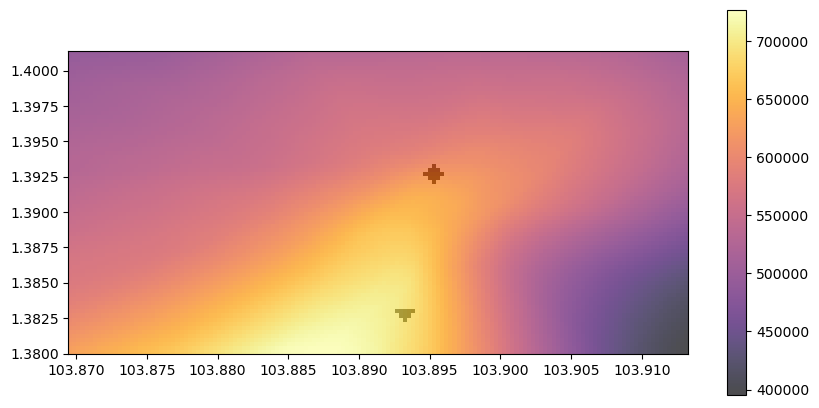

In [26]:
def min_coords(long,lat):
  return (np.abs((longs-long)).argmin(), np.abs(lats-lat).argmin())
mrt_map = np.zeros((n2,n1))
#mrts = ["Yio Chu Kang MRT", "Ang Mo Kio MRT"]
#for mrt in mrts:
#  (i,j) = min_coords(*longLats[mrt])
#  #for m in range(3):
#  #  for n in range(3):
#  mrt_map[j+m-1][i+n-1] = 1

(i,j) = min_coords(*longLats[mrts[0]])
# down
mrt_map[j-1][i]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j+1][i-2]=1
mrt_map[j+1][i-1]=1
mrt_map[j+1][i+2]=1
mrt_map[j+1][i+1]=1
mrt_map[j+1][i]=1


"""
# up
(i,j) = min_coords(*longLats[mrts[0]])
mrt_map[j+1][i]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j-1][i-2]=1
mrt_map[j-1][i-1]=1
mrt_map[j-1][i+2]=1
mrt_map[j-1][i+1]=1
mrt_map[j-1][i]=1
(i,j) = min_coords(*longLats[mrts[0]])
#left
mrt_map[j-2][i+1]=1
mrt_map[j-1][i+1]=1
mrt_map[j-1][i]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j+1][i]=1
mrt_map[j+1][i+1]=1
mrt_map[j+2][i+1]=1
(i,j) = min_coords(*longLats[mrts[2]])
mrt_map[j-2][i-1]=1
mrt_map[j-1][i-1]=1
mrt_map[j-1][i]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j+1][i]=1
mrt_map[j+1][i-1]=1
mrt_map[j+2][i-1]=1
"""
(i,j) = min_coords(*longLats[mrts[1]])
mrt_map[j+1][i]=1
mrt_map[j+1][i-1]=1
mrt_map[j+1][i+1]=1
mrt_map[j-1][i]=1
mrt_map[j-1][i+1]=1
mrt_map[j-1][i-1]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j][i-2]=1
mrt_map[j][i+2]=1
mrt_map[j+2][i]=1
mrt_map[j-2][i]=1

fig,ax=plt.subplots()
#mrt
#color map
shw2 = ax.imshow(mrt_map, extent=[longLeft, longRight, latLeft, latRight], origin='lower',cmap='Greys',alpha=1.0)
shw = ax.imshow(prices, extent=[longLeft, longRight, latLeft, latRight], origin='lower',alpha=0.7, cmap='inferno')
bar = plt.colorbar(shw)
fig.set_figwidth(10)
fig.set_figheight(10/n1*n2)

plt.show()

In [27]:
longLeft,longRight

(103.8694542, 103.91329979999999)

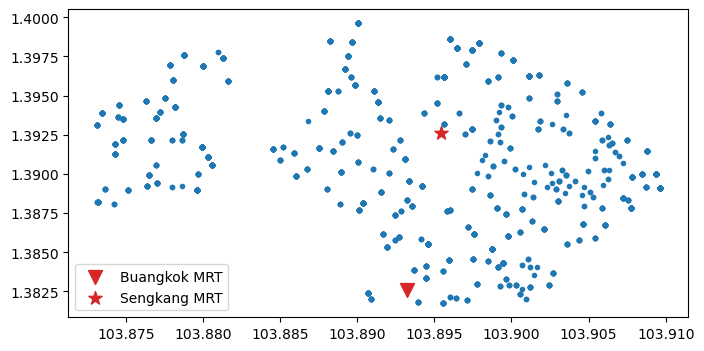

In [29]:
markers = ["v", "*"]

fig,ax2=plt.subplots()
ax2.scatter(df.long,df.lat,marker='.')
for i,mrt in enumerate(mrts):
  ax2.scatter([longLats[mrt][0]], [longLats[mrt][1]],marker=markers[i],c='#d62728',label=mrt,s=100)
ax2.legend(loc='lower left')
fig.set_figwidth(8)
fig.set_figheight(8/n1*n2)

plt.show()


for mrt in mrts:
  (i,j) = min_coords(*longLats[mrt])
